In [12]:
import codecs
import glob
import logging
import os
import re
import scipy
import spacy
import logging
import sys
import string
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import bokeh.plotting as bp
import matplotlib.pyplot as plt
from scipy.stats import mode
from time import time
from string import punctuation
from nltk.corpus import gutenberg, stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
from collections import Counter
from sklearn import ensemble
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split,cross_val_score, KFold, cross_val_predict, GridSearchCV, StratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.linear_model.stochastic_gradient import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import SpectralClustering, MeanShift, estimate_bandwidth, AffinityPropagation, KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import Normalizer, normalize
from sklearn.manifold import TSNE
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook
from sklearn.neural_network import MLPClassifier
%matplotlib inline

### Introduction ###

The purpose of this challenge is to classify authors using different novels that they have written. In this case unsupervised and supervised techniques have been used and compared to see which one is giving better results. Regarding the corpus, then authors have been chosen randomly from Gutenberg Project and 7 novels from those authors. Although initially ten novesl were picked, due to computing restrictions only seven have been left for the classification purposes. The authors that have been picked are:

1. Jane Austen
2. Chesterton
3. Conan Doyle
4. Charles Dickens
5. Elliot
6. Huxley
7. Shakespeare
8. Shaw
9. H.G. Wells
10. Oscar Wilde

In this notebook we will see the following steps:

1. Retrieve and store the data creating the dataset
2. Cleanse and parse and tokenize texts
3. Generate features and select the most appropiate for the models
4. Dimensionality reduction and similarity between author using LSA and T-SNE
5. Cluster authors
6. Supervised models
7. Conclusions

To run the unsupervised and supervised parts of this challenge a new virtual machine has been set up to improve the computational performance. After initial trials on the machine with increased RAM 12GB, the conditions of the challenge were too resource intensive reasing why a virtual machine 8 vCPUs, 30 GB memory was set using Google Compute Engine.

### 1. Retrieve and store data creating the dataset ###

Seven novels from ten different authors have been retrieved form Gutenberg project and a list of all the book files is created.

In [6]:
# Create a list of all of our book files.
book_filenames_austen = sorted(glob.glob("/home/borjaregueral/train/austen/*.txt"))
book_filenames_chesterton = sorted(glob.glob("/home/borjaregueral/train/chesterton/*.txt"))
book_filenames_conandoyle = sorted(glob.glob("/home/borjaregueral/train/conandoyle/*.txt"))
book_filenames_dickens = sorted(glob.glob("/home/borjaregueral/train/dickens/*.txt"))
book_filenames_elliot = sorted(glob.glob("/home/borjaregueral/train/elliot/*.txt"))
book_filenames_huxley = sorted(glob.glob("/home/borjaregueral/train/huxley/*.txt"))
book_filenames_shakespeare = sorted(glob.glob("/home/borjaregueral/train/shakespeare/*.txt"))
book_filenames_shaw = sorted(glob.glob("/home/borjaregueral/train/shaw/*.txt"))
book_filenames_wells = sorted(glob.glob("/home/borjaregueral/train/wells/*.txt"))
book_filenames_wilde = sorted(glob.glob("/home/borjaregueral/train/wilde/*.txt"))

The information is added to the copus and stored as raw books so that they can be cleansed

In [7]:
#Read and add the text of each book to corpus_raw.
corpus_raw_austen = u""
for book_filename in book_filenames_austen:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw_austen += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw_austen)))
    print()
    
#Read and add the text of each book to corpus_raw.
corpus_raw_chesterton = u""
for book_filename in book_filenames_chesterton:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw_chesterton += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw_chesterton)))
    print()
    
#Read and add the text of each book to corpus_raw.
corpus_raw_conandoyle = u""
for book_filename in book_filenames_conandoyle:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw_conandoyle += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw_conandoyle)))
    print()

#Read and add the text of each book to corpus_raw.
corpus_raw_dickens = u""
for book_filename in book_filenames_dickens:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw_dickens += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw_dickens)))
    print()

#Read and add the text of each book to corpus_raw.
corpus_raw_elliot = u""
for book_filename in book_filenames_elliot:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw_elliot += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw_elliot)))
    print()    
    
#Read and add the text of each book to corpus_raw.
corpus_raw_huxley = u""
for book_filename in book_filenames_huxley:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw_huxley += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw_huxley)))
    print()

#Read and add the text of each book to corpus_raw.
corpus_raw_shakespeare = u""
for book_filename in book_filenames_shakespeare:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw_shakespeare += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw_shakespeare)))
    print()
    
#Read and add the text of each book to corpus_raw.
corpus_raw_shaw = u""
for book_filename in book_filenames_shaw:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw_shaw += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw_shaw)))
    print()
    
#Read and add the text of each book to corpus_raw.
corpus_raw_wells = u""
for book_filename in book_filenames_wells:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw_wells += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw_wells)))
    print()
    
#Read and add the text of each book to corpus_raw.
corpus_raw_wilde = u""
for book_filename in book_filenames_wilde:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw_wilde += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw_wilde)))
    print()
    
#Create a list with all the corpus   
doc_complete = [corpus_raw_austen, corpus_raw_chesterton,
                corpus_raw_conandoyle, corpus_raw_dickens,
                corpus_raw_elliot, corpus_raw_huxley,
                corpus_raw_shakespeare, corpus_raw_shaw,
               corpus_raw_wells, corpus_raw_wilde]

#Calculate the length of the corpus
len(corpus_raw_austen + corpus_raw_chesterton +
                corpus_raw_conandoyle + corpus_raw_dickens +
                corpus_raw_elliot + corpus_raw_huxley +
                corpus_raw_shakespeare + corpus_raw_shaw +
               corpus_raw_wells + corpus_raw_wilde)

#Close the book file 
book_file.close()

Reading '/home/borjaregueral/train/austen/austen-emma.txt'...
Corpus is now 795775 characters long

Reading '/home/borjaregueral/train/austen/austen-loveandfriendship.txt'...
Corpus is now 980773 characters long

Reading '/home/borjaregueral/train/austen/austen-mansfield.txt'...
Corpus is now 1549557 characters long

Reading '/home/borjaregueral/train/austen/austen-northanger.txt'...
Corpus is now 1990819 characters long

Reading '/home/borjaregueral/train/austen/austen-persuasion.txt'...
Corpus is now 2457111 characters long

Reading '/home/borjaregueral/train/austen/austen-pride_and_prejudice.txt'...
Corpus is now 3167694 characters long

Reading '/home/borjaregueral/train/chesterton/chesterton-allthingsconsidered.txt'...
Corpus is now 337803 characters long

Reading '/home/borjaregueral/train/chesterton/chesterton-ballad.txt'...
Corpus is now 452044 characters long

Reading '/home/borjaregueral/train/chesterton/chesterton-brown.txt'...
Corpus is now 858673 characters long

Reading '

### 2. Cleanse and parse and tokenize text###

Before generating the features, and to increase the explanatory power of them, text has been cleaned and parsed accordingly.  The books have gone through an initial set of cleansing actions before been parsed using Spacy, to reduce the computing effort required by the latter and then have been cleaned again before the feature generation.

The initial cleansing action has had three steps. The first step consisted on deleting all references to the Gutenberg Project from every book. This way, it has been avoided that words like “Gutenberg” and “Gutenberg Project” appear as features and distort the clustering of the authors.

As described below, cleaning actions have gone from removing all references to chapters, digits double whitespaces and references to numbers like dates and ordinal numbers. This has been followed by removing punctuation and common stop words that will only add noise to the features that are generated afterwards.

The remaining words, considered to have the most explanatory power regarding each of the titles from the authors, have been lemmatized and stemmed reducing up to 60% the computing resources needed. In the first case words from the same family are reduced to their lemmas and in the second case, additional prefixes and suffixes are removed. All cleaning operations have been carried out in a way that remaining sentences are stored in a list of lists.

In [8]:
#Create a set of stopwords in english from nltk
stop = set(stopwords.words('english'))

# Create a set of punctuation marks to exclude them from the text
exclude = set(string.punctuation) 

#List of words that are in the books and can be removed from the text as they add noise
comms = ['im','mr', 'miss', 'lady', 'sir', 'man', 'it', 'i', 'u', 'you', 'one'] 

# Call the lemmatizer and the Stemmer
lemma = WordNetLemmatizer()
stemms = PorterStemmer()

#Define a cleaning function that incorporates the different steps in the pipeline to clean the texts

def clean(doc):
    #Delete '--' from texts, specially used by Austen
    doc = re.sub(r'--','',doc) 
    doc = re.sub("[\[].*?[\]]", "", doc) #
    #Remove references to chapters
    doc = re.sub(r'Chapter \d+', '', doc) 
    doc = re.sub(r'CHAPTER .*', '', doc)
    #Substitute numbers by spaces
    doc = re.sub('[0-9]+', '', doc)
    #Remove digits and expressions such as 11th
    doc = re.sub("\s\s+", " ", doc)
    doc = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", doc)
    #Remove quotes
    doc = doc.replace('“', '').replace('”', '').replace('"', '').replace('‘', '').replace('’', '')
    #Remove stop words
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    #Remove punctuation
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    #Remove common words
    commonalities_free = " ".join([i for i in punc_free.lower().split() if i not in comms])
    #Lemmatize and stem words to reduce the total amount of words
    lemmatized = " ".join(lemma.lemmatize(word) for word in commonalities_free.split())
    normalized = " ".join(stemms.stem(word) for word in lemmatized.split())
    return normalized

#Create a list of lists with all the documents
doc_clean = [clean(doc) for doc in doc_complete]

After the initial cleaning, novels are parsed using Spacy to tokenize and label the data and each of the set of words is identified by author. At this point, the integrity of the novels is lost and the dataset consists on tokens from different authors tagged to each of them. This will be useful for further operations and especially when using further supervised and unsupervised classification techniques.

In [9]:
# Parse the cleaned novels
#load spacy for english language as all novels are in english
nlp = spacy.load('en')

#Parse novels one by one to maintain the author tagging
austen_doc = nlp(doc_clean[0])
chesterton_doc = nlp(doc_clean[1])
conandoyle_doc = nlp(doc_clean[2])
dickens_doc = nlp(doc_clean[3])
elliot_doc = nlp(doc_clean[4])
huxley_doc = nlp(doc_clean[5])
shakespeare_doc = nlp(doc_clean[6])
shaw_doc = nlp(doc_clean[7])
wells_doc = nlp(doc_clean[8])
wilde_doc = nlp(doc_clean[9])

Tokens are grouped into sentences and labelled in a dataframe. A Target column is added to the dataframe for further use when classifying texts using supervised techniques. Some additional cleansing of the sentences has been carried out. Sentences under 50 words have been removed from the dataset, duplicates and empty rows.Additionally the length of each sentence has been added to the daataframe.

The graph below reflects the total number of characters and the contribution of each of the corpus to the total corpora. As titles were picked randomly, the contribution of each corpora is different by each author being the biggest Elliot and the smallest Huxley with nearly 8000 and 1500 contribution each.

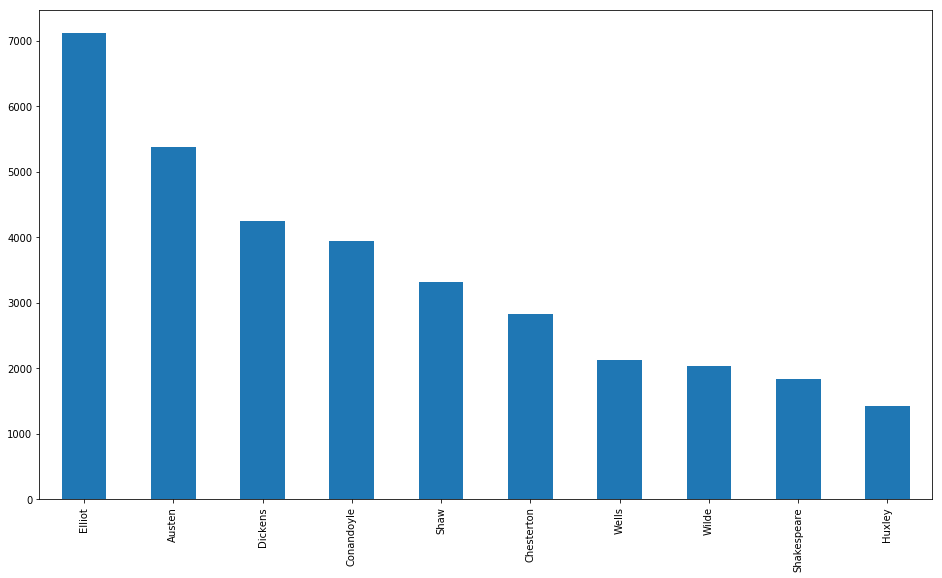

In [10]:
# Group into sentences.
austen_sents = [[str(sent), "Austen"] for sent in austen_doc.sents]
chesterton_sents = [[str(sent), "Chesterton"] for sent in chesterton_doc.sents]
conandoyle_sents = [[str(sent), "Conandoyle"] for sent in conandoyle_doc.sents]
dickens_sents = [[str(sent), "Dickens"] for sent in dickens_doc.sents]
elliot_sents = [[str(sent), "Elliot"] for sent in elliot_doc.sents]
huxley_sents = [[str(sent), "Huxley"] for sent in huxley_doc.sents]
shakespeare_sents = [[str(sent), 'Shakespeare'] for sent in shakespeare_doc.sents]
shaw_sents = [[str(sent), "Shaw"] for sent in shaw_doc.sents]
wells_sents = [[str(sent), "Wells"] for sent in wells_doc.sents]
wilde_sents = [[str(sent), "Wilde"] for sent in wilde_doc.sents]

#Combine the sentences from the two novels into one data frame.
names = ['Sentences','Author']
sentences = pd.DataFrame(austen_sents + chesterton_sents + conandoyle_sents +
                         dickens_sents + elliot_sents + huxley_sents + 
                         shakespeare_sents + shaw_sents + wells_sents +
                         wilde_sents, columns = names)

#Aadd numerical column to tag the authors for supervised classification
sentences.loc[sentences['Author'] == 'Austen', 'Target'] = 0
sentences.loc[sentences['Author'] == 'Chesterton', 'Target'] = 1
sentences.loc[sentences['Author'] == 'Conandoyle', 'Target'] = 2
sentences.loc[sentences['Author'] == 'Dickens', 'Target'] = 3
sentences.loc[sentences['Author'] == 'Elliot', 'Target'] = 4
sentences.loc[sentences['Author'] == 'Huxley', 'Target'] = 5
sentences.loc[sentences['Author'] == 'Shakespeare', 'Target'] = 6
sentences.loc[sentences['Author'] == 'Shaw', 'Target'] = 7
sentences.loc[sentences['Author'] == 'Wells', 'Target'] = 8
sentences.loc[sentences['Author'] == 'Wilde', 'Target'] = 9

#Add length of sentences to the Dataframe
sentences['len'] = sentences['Sentences'].map(len)

#Remove duplicate description columns to avoid having the initial and final information about Gutenberg project
sentences = sentences.drop_duplicates('Sentences')

#Remove rows that are empty during the cleaning process
sentences = sentences[~sentences['Sentences'].isnull()]

#remove sentences with length smaller than 50 characters to reduce the noise in the data
sentences = sentences[sentences.len > 50]
sentences.reset_index(inplace=True)
sentences.drop('index', inplace=True, axis=1)

#Plot the contribution of each author to the corpus (sentences)
sentences.Author.value_counts().plot(kind='bar', grid=False, figsize=(16, 9))

The last part of the cleansing activity has been done removing words that were appearing in all clusters and that after some “trial and error” have been visually identified and taken out. Furthermore tokens have been lowercased and only non-numeric ones have been kept. Although this cleansing activity was already done, further investigation of the common words per author showed that some of them remained. 

Tokens have been added to the dataframe that will act as the starting point for the features generation

In [13]:
#Define the tokenizer: from sentences to tokens
def tokenizer(text):
    try:
        tokens_ = [word_tokenize(sent) for sent in sent_tokenize(text)]
        
        tokens = []
        for token_by_sent in tokens_:
            tokens += token_by_sent
        #Remove corpus specific stop words: Manually remove common words that appear in novels that dont add much value
        tokens = list(filter(lambda t: t not in ['im', 'Mr','mr','t','her', 'miss', 'lady', 'sir', 'said', 'say',
                                                 'man','woman','could','would','like', 'look', 'make', 'do', 'know',
                                                 'upon', 'never', 'see', 'well', 'him', 'me', 'it', 'i', 'u',
                                                 'you', 'one', 'gutenbergtm', 'project', 'gutenberg project'], tokens))
       
        #Manually remove contractions that appear in the novels
        tokens = list(filter(lambda t: t not in [u"'s", u"n't", u"...", u"''", u'``', u'\u2014', u'\u2026', u'\u2013'], tokens))
        
        #Filter tokens that are words removing numbers
        filtered_tokens = []
        for token in tokens:
            if re.search('[a-zA-Z]', token):
                filtered_tokens.append(token)

        filtered_tokens = list(map(lambda token: token.lower(), filtered_tokens))

        return filtered_tokens
    except Error as e:
        print(e)

#Tokenize sentences to tokens
sentences['tokens'] = sentences['Sentences'].map(tokenizer)

The ten most common words per author have been identified and showed in the graph below. It can be observed that after the two cleansing stages, there are verbs that still appear such in different forms. Special attention has been taken to Dickens and Wells which have very similar common words. A function has been created "keywords" to count the most common words.

In [14]:
#Define the function that will bring the 10 most common tokens per author
def keywords(Author):
    tokens = sentences[sentences['Author'] == Author]['tokens']
    alltokens = []
    for token_list in tokens:
        alltokens += token_list
    counter = Counter(alltokens)
    return counter.most_common(5)

#Define and print the 10 most common words per author
for Author in set(sentences['Author']):
    print('Author :', Author)
    print('top 10 keywords:', keywords(Author))
    print('---')

Author : Elliot
top 10 keywords: [('go', 1522), ('littl', 1497), ('come', 1428), ('think', 1419), ('might', 1348)]
---
Author : Conandoyle
top 10 keywords: [('come', 967), ('holm', 956), ('hand', 931), ('may', 854), ('two', 810)]
---
Author : Shaw
top 10 keywords: [('go', 713), ('come', 666), ('that', 522), ('think', 505), ('take', 467)]
---
Author : Wilde
top 10 keywords: [('lord', 1104), ('life', 611), ('chiltern', 542), ('thing', 540), ('go', 405)]
---
Author : Shakespeare
top 10 keywords: [('thou', 727), ('thi', 638), ('king', 585), ('haue', 585), ('shall', 526)]
---
Author : Dickens
top 10 keywords: [('littl', 1076), ('come', 862), ('hand', 819), ('go', 760), ('time', 729)]
---
Author : Chesterton
top 10 keywords: [('thing', 1019), ('even', 701), ('men', 612), ('brown', 584), ('think', 572)]
---
Author : Austen
top 10 keywords: [('must', 1567), ('much', 1425), ('think', 1292), ('littl', 1020), ('might', 1011)]
---
Author : Wells
top 10 keywords: [('thing', 711), ('littl', 633), ('

### Feature Generation ###

Data has been vectorized using Tf-idf techniques so that authors with shorter texts are not penalized. The features have been normalized and the ngrmas used range from one to four. additionally, tokens that appear in less than three documents or in more than 80% of the documents have been removed to create our own corpus. Tokens like "must", "think", "said" have been removed as they don´t add a lot of information

This has been done after running the tfidf vectorization process to improve the quality of the clustering as the common words from previous analysis seem to be similar between authors. Once more stopwords have been removed.

In this case, the stop words used are the ones that are included in the NLTK package. For further classification purposes, data has been split into train and test dataset with a 75/25 split. 

In [18]:
#Transform into Tf-idf
vect = TfidfVectorizer(norm = 'l2', #Aplly l2 normalizer to the features
                       max_df = 0.8, #Remove terms that appear in 80% of the documents to remove corpus-specific stop words
                       min_df = 3, #Remove features that appear in less than 3 documents
                       ngram_range = (1,4), #to include meaningful features consider ngrams up to 4 tokens
                       use_idf = True,#use idf to smoothen the word count and consider frequency
                       stop_words = 'english',
                       lowercase = False,#As sanity check remove the english stop-words
                       sublinear_tf = True)

#Transform words into features and define the labels
X = vect.fit_transform(sentences['Sentences'])
y = sentences['Author']

#Split the dataset into a training and testing dataset
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X, y,test_size=0.75, random_state=42)

#Shape if the feautures
X_train_tfidf.shape

(8557, 85859)

To generate features using bag od words, countvectorizer has been used. Although thw frequencies with which words appear are not normalized, they have been generated to see the impact on the different classification methods. In this case the parameters are tuned to the same values. The absence of noramlization will introduce more noise in the features which will give lower results in terms of accuracy. If this is not the case, it will indicate that the model has not been properly tunned.

In [10]:
#Create a dictionary to put the features and idf values for each of them
tfidf = dict(zip(vect.get_feature_names(), vect.idf_))

#Create dataframe and sort them
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf), orient='index')
tfidf.columns = ['tfidf']

The five most important tokens are ngrams of four terms which is aligned with the strategy used for feature generation

In [11]:
#Show the first five features according to the highest tfidf value
tfidf.sort_values(by=['tfidf'], ascending=False).head()

,tfidf
éclat,10.054534
price mean,10.054534
primu scoena,10.054534
primordi form,10.054534
prime object,10.054534


The tokens that have the lower tfidf scores are quite generic not being very informative of each novel

In [12]:
#Show the last five features according to the lowerst tfidf value
tfidf.sort_values(by=['tfidf'], ascending=True).head()

,tfidf
said,2.368372
like,2.737654
look,2.876943
come,2.886532
know,2.903441


The graph belows shows the frequency and distribution of the weights that tfidf assigns to words

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f726fc36ba8>]], dtype=object)

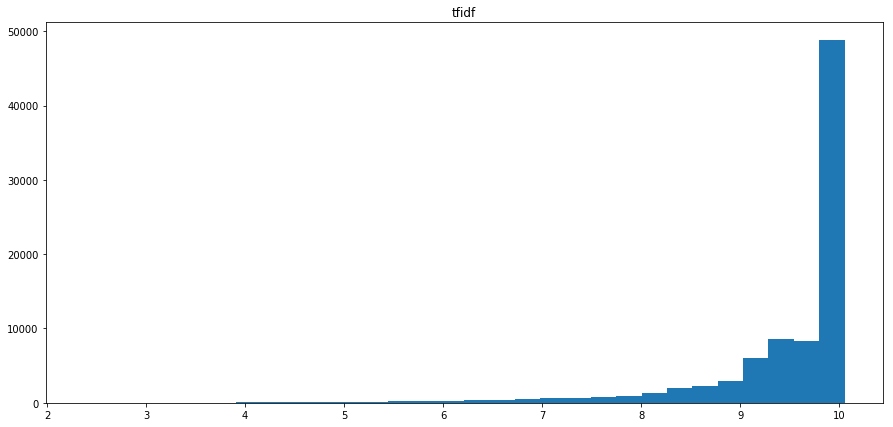

In [13]:
#Plot the frequency of the tfidf values
tfidf.hist(bins=30, grid=False, figsize=(15,7))

In the graph above it can be seen how the the most common words tfidf gravitate around higher values of tfidf. From 2 to 4 the frequency values are too low to be captured with the present number of bins. After reducing the frequency, those values appear but the representation of the whole distribution is lost.

In [14]:
#Transform into Tf-idf
cvect = CountVectorizer(
                       max_df = 0.8, #Remove terms that appear in 80% of the documents to remove corpus-specific stop words
                       min_df = 3, #Remove features that appear in less than 3 documents
                       ngram_range = (1,4), #to include meaningful features consider ngrams up to 4 tokens
                       stop_words = 'english',
                       lowercase = False,#As sanity check remove the english stop-words
                      # sublinear_tf = True
                      )

#Transform words into features and define the labels
X = cvect.fit_transform(sentences['Sentences'])
y = sentences['Target']

#Split the dataset into a training and testing dataset
X_train_cvec, X_test_cvec, y_train_cvec, y_test_cvec = train_test_split(X, y,test_size=0.75, random_state=42)

#Shape if the feautures
X_train_cvec.shape

(8557, 85859)

### 4. Dimensionality reduction and similarity between author using LSA and T-SNE ###

It can be seen that the number of features generated by bag of words is doubling the features generated by tfidf. One of the reasons is that is considering words that are repeated under the same authors but within the threshhold.

To do some dimensionality reduction Truncated SVS has been used. This technique has been used instead of PCA as PCA identifies the features that explain most of the variance in the data while SVD as part of LDA tries to identify the attributes that account for the most variance between classes. This will be used not only for clustering purposes but also to see the similarity and stability of clusters. 

The number of components that has been chosen is between the range of 200-500 considered as reasonable for the amount of initial features. Latent Semantic Analysis (also called Latent Semantic Indexing) is the process of applying PCA to a tf-idf term-document matrix. What we get, in the end, is clusters of terms that presumably reflect a topic. Each document will get a score for each topic, with higher scores indicating that the document is relevant to the topic. Documents can pertain to more than one topic

In [19]:
#Determine the number of components
n_components = 400

#Call and initialize the model
svd = TruncatedSVD(n_components=n_components, random_state=123)

#Initialize the normalizer
normalizer = Normalizer(copy=False)

#Create the pipeline with both SVD and the normalizer
lsa = make_pipeline(svd, normalizer)

#Define the predictors following LSA analysis
X_train_lsa = lsa.fit_transform(X_train_tfidf)

#Build a dataframe with the author by component
author_by_component=pd.DataFrame(X_train_lsa,index=y_train)

#% of variance explained by the number of components that has been chosen
variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()

#Print total variance captured by components
print("Percent variance captured by all components:",total_variance*100)

#Show similarity between authors for all components
for i in range(n_components):
    print('Component {}:'.format(i))
    print(author_by_component.loc[:,i].sort_values(ascending=False)[1:10])

Percent variance captured by all components: 20.0053323575
Component 0:
Author
Austen        0.528213
Chesterton    0.526083
Austen        0.525965
Elliot        0.523123
Elliot        0.522965
Conandoyle    0.522294
Huxley        0.520682
Chesterton    0.510337
Elliot        0.503838
Name: 0, dtype: float64
Component 1:
Author
Wells         0.378003
Wells         0.374279
Wells         0.356191
Wells         0.351920
Conandoyle    0.351829
Wells         0.349342
Conandoyle    0.347958
Chesterton    0.346068
Wells         0.338941
Name: 1, dtype: float64
Component 2:
Author
Wilde         0.303846
Wilde         0.299839
Dickens       0.299808
Dickens       0.294547
Conandoyle    0.291930
Wilde         0.289873
Dickens       0.288837
Dickens       0.287270
Dickens       0.286382
Name: 2, dtype: float64
Component 3:
Author
Wilde    0.419576
Wilde    0.400772
Wilde    0.389076
Wilde    0.386714
Wilde    0.384253
Wilde    0.380639
Wilde    0.379490
Wilde    0.374999
Wilde    0.370718
Name: 

Author
Chesterton    0.202684
Elliot        0.195069
Dickens       0.189513
Shaw          0.189089
Shaw          0.183625
Shaw          0.183108
Dickens       0.178833
Elliot        0.177646
Wells         0.177534
Name: 87, dtype: float64
Component 88:
Author
Huxley        0.252199
Chesterton    0.227287
Austen        0.213508
Shaw          0.212047
Dickens       0.208381
Conandoyle    0.201746
Austen        0.199251
Dickens       0.195552
Elliot        0.192920
Name: 88, dtype: float64
Component 89:
Author
Wilde      0.199277
Austen     0.186610
Elliot     0.182929
Dickens    0.179052
Dickens    0.168207
Wilde      0.167994
Dickens    0.164038
Elliot     0.162965
Austen     0.160064
Name: 89, dtype: float64
Component 90:
Author
Elliot     0.217204
Austen     0.204280
Elliot     0.195787
Elliot     0.183022
Austen     0.180349
Elliot     0.177903
Wells      0.165212
Dickens    0.162805
Elliot     0.160910
Name: 90, dtype: float64
Component 91:
Author
Wilde         0.170143
Wilde       

Author
Shaw          0.177983
Wells         0.174628
Conandoyle    0.169922
Elliot        0.167898
Chesterton    0.167431
Elliot        0.166914
Elliot        0.161474
Dickens       0.156591
Austen        0.154674
Name: 170, dtype: float64
Component 171:
Author
Chesterton    0.182781
Elliot        0.182097
Wells         0.180986
Austen        0.177265
Dickens       0.174112
Chesterton    0.173315
Wells         0.173032
Elliot        0.169284
Elliot        0.164390
Name: 171, dtype: float64
Component 172:
Author
Wilde          0.192638
Shakespeare    0.192190
Wilde          0.190329
Shakespeare    0.186350
Austen         0.177228
Elliot         0.175209
Elliot         0.172689
Chesterton     0.171545
Shakespeare    0.167959
Name: 172, dtype: float64
Component 173:
Author
Shakespeare    0.200931
Shakespeare    0.191059
Huxley         0.180131
Shakespeare    0.172303
Elliot         0.166119
Shakespeare    0.159575
Elliot         0.158919
Chesterton     0.157114
Shakespeare    0.154800
Nam

Component 257:
Author
Elliot        0.182117
Huxley        0.155463
Wilde         0.147227
Elliot        0.142447
Dickens       0.140462
Chesterton    0.139456
Elliot        0.138844
Austen        0.138742
Elliot        0.136104
Name: 257, dtype: float64
Component 258:
Author
Elliot         0.172705
Shaw           0.165289
Shakespeare    0.165210
Huxley         0.164212
Conandoyle     0.158054
Chesterton     0.157893
Elliot         0.157157
Wilde          0.156362
Dickens        0.154665
Name: 258, dtype: float64
Component 259:
Author
Wilde         0.184874
Elliot        0.167200
Conandoyle    0.164902
Huxley        0.161532
Elliot        0.157565
Elliot        0.157249
Chesterton    0.156782
Shaw          0.152917
Elliot        0.151385
Name: 259, dtype: float64
Component 260:
Author
Austen        0.174430
Conandoyle    0.172026
Austen        0.168570
Conandoyle    0.160034
Elliot        0.154592
Chesterton    0.148544
Wells         0.144409
Conandoyle    0.143981
Conandoyle    0.1387

Author
Shakespeare    0.163606
Austen         0.160603
Elliot         0.157597
Elliot         0.156446
Huxley         0.152293
Wilde          0.150163
Dickens        0.148559
Conandoyle     0.147708
Chesterton     0.146403
Name: 339, dtype: float64
Component 340:
Author
Austen         0.172456
Wells          0.169432
Shaw           0.160250
Elliot         0.152430
Conandoyle     0.151051
Shakespeare    0.148796
Dickens        0.148545
Huxley         0.138301
Wells          0.138208
Name: 340, dtype: float64
Component 341:
Author
Elliot         0.161476
Shakespeare    0.159985
Huxley         0.159457
Elliot         0.143805
Dickens        0.143311
Dickens        0.142409
Austen         0.139879
Huxley         0.136902
Conandoyle     0.136794
Name: 341, dtype: float64
Component 342:
Author
Chesterton     0.175047
Shakespeare    0.153918
Conandoyle     0.152298
Elliot         0.151459
Elliot         0.148507
Wells          0.148213
Elliot         0.146881
Dickens        0.142249
Austen   

Similarity between authors can be seen in the components, in the first one, component 0 nearly all authors appear mixed although component 1 starst filterinfg between authors and Wells appears on its own. In component 2 the authors appear to be mixed again Wilde, Dickes and Conandoyle. This can be due to the type of tfidf features that LSA is considering to build the features, being a lieanr combination of them. If phrases appear to be close enough as they are standar in english, then authors appear to be mixed while they are split when the features are more relevant, bring more information about their repsective novels.

In [20]:
#Determine the number of components
n_components = 400

#Call and initialize the model
svd = TruncatedSVD(n_components=n_components, random_state=123)

#Initialize the normalizer
normalizer = Normalizer(copy=False)

#Create the pipeline with both SVD and the normalizer
lsa = make_pipeline(svd, normalizer)

#Define the predictors following LSA analysis
X_test_lsa = lsa.fit_transform(X_test_tfidf)

#Build a dataframe with the author by component
author_by_component=pd.DataFrame(X_test_lsa,index=y_test)

#Show similarity between authors for all components
for i in range(n_components):
    print('Component {}:'.format(i))
    print(author_by_component.loc[:,i].sort_values(ascending=False)[0:5])

Component 0:
Author
Elliot    0.630703
Elliot    0.600213
Elliot    0.600063
Elliot    0.593702
Shaw      0.586851
Name: 0, dtype: float64
Component 1:
Author
Conandoyle    0.429529
Wells         0.428753
Conandoyle    0.424799
Wilde         0.411126
Wells         0.399938
Name: 1, dtype: float64
Component 2:
Author
Huxley    0.458126
Huxley    0.457989
Huxley    0.456940
Huxley    0.450095
Huxley    0.446308
Name: 2, dtype: float64
Component 3:
Author
Shakespeare    0.428549
Shakespeare    0.391801
Shakespeare    0.385884
Shakespeare    0.384618
Shakespeare    0.383847
Name: 3, dtype: float64
Component 4:
Author
Wilde    0.533600
Wilde    0.507246
Wilde    0.503940
Wilde    0.497217
Wilde    0.493992
Name: 4, dtype: float64
Component 5:
Author
Wilde    0.398693
Wilde    0.383797
Wilde    0.380555
Wilde    0.378656
Wilde    0.371391
Name: 5, dtype: float64
Component 6:
Author
Wilde    0.435300
Wilde    0.429126
Wilde    0.427704
Wilde    0.427656
Wilde    0.427421
Name: 6, dtype: float

Author
Shaw          0.298955
Shaw          0.295436
Shaw          0.277651
Chesterton    0.271358
Elliot        0.253429
Name: 69, dtype: float64
Component 70:
Author
Shaw    0.351496
Shaw    0.341950
Shaw    0.315887
Shaw    0.313217
Shaw    0.303935
Name: 70, dtype: float64
Component 71:
Author
Austen        0.285825
Shaw          0.263620
Elliot        0.256645
Conandoyle    0.247836
Huxley        0.242284
Name: 71, dtype: float64
Component 72:
Author
Shaw    0.286983
Shaw    0.286237
Shaw    0.275219
Shaw    0.273855
Shaw    0.272837
Name: 72, dtype: float64
Component 73:
Author
Dickens       0.310437
Dickens       0.282267
Chesterton    0.278552
Austen        0.260368
Austen        0.260241
Name: 73, dtype: float64
Component 74:
Author
Dickens       0.267227
Dickens       0.262616
Elliot        0.230907
Austen        0.227569
Conandoyle    0.226387
Name: 74, dtype: float64
Component 75:
Author
Shaw      0.277485
Shaw      0.247982
Austen    0.246569
Elliot    0.243151
Elliot    0

Author
Huxley        0.246536
Austen        0.244537
Wilde         0.239125
Conandoyle    0.237880
Huxley        0.225300
Name: 145, dtype: float64
Component 146:
Author
Conandoyle     0.212052
Elliot         0.208121
Shakespeare    0.203641
Dickens        0.188862
Austen         0.187762
Name: 146, dtype: float64
Component 147:
Author
Dickens       0.232718
Elliot        0.226443
Chesterton    0.220862
Wilde         0.211516
Dickens       0.202391
Name: 147, dtype: float64
Component 148:
Author
Shaw      0.234667
Wilde     0.233933
Austen    0.231778
Austen    0.228816
Austen    0.225928
Name: 148, dtype: float64
Component 149:
Author
Wilde      0.265737
Dickens    0.247450
Wilde      0.242979
Dickens    0.237804
Dickens    0.230411
Name: 149, dtype: float64
Component 150:
Author
Shakespeare    0.248405
Shakespeare    0.239540
Dickens        0.238903
Dickens        0.237751
Dickens        0.237340
Name: 150, dtype: float64
Component 151:
Author
Dickens       0.219379
Conandoyle    0.2

Author
Wells         0.236978
Conandoyle    0.200394
Wells         0.190876
Huxley        0.190153
Elliot        0.185601
Name: 220, dtype: float64
Component 221:
Author
Wilde      0.196993
Dickens    0.196811
Dickens    0.187213
Dickens    0.182918
Dickens    0.178455
Name: 221, dtype: float64
Component 222:
Author
Chesterton    0.251926
Elliot        0.208715
Elliot        0.203446
Conandoyle    0.197948
Austen        0.195064
Name: 222, dtype: float64
Component 223:
Author
Dickens        0.219407
Shakespeare    0.214244
Chesterton     0.208008
Conandoyle     0.185072
Conandoyle     0.181737
Name: 223, dtype: float64
Component 224:
Author
Shaw       0.216188
Huxley     0.197683
Austen     0.194104
Dickens    0.187384
Wells      0.180060
Name: 224, dtype: float64
Component 225:
Author
Austen     0.216706
Wells      0.204817
Elliot     0.190320
Elliot     0.188104
Dickens    0.186321
Name: 225, dtype: float64
Component 226:
Author
Chesterton    0.217363
Elliot        0.201782
Elliot   

Author
Wells     0.225309
Wells     0.201463
Shaw      0.196687
Elliot    0.188024
Austen    0.187289
Name: 299, dtype: float64
Component 300:
Author
Wells         0.228819
Conandoyle    0.194913
Shaw          0.174161
Austen        0.170269
Wilde         0.168278
Name: 300, dtype: float64
Component 301:
Author
Wells      0.191532
Shaw       0.191120
Austen     0.176589
Wells      0.171607
Dickens    0.170750
Name: 301, dtype: float64
Component 302:
Author
Conandoyle    0.204596
Conandoyle    0.188634
Wilde         0.185144
Dickens       0.183165
Austen        0.182926
Name: 302, dtype: float64
Component 303:
Author
Austen        0.216652
Huxley        0.187581
Wilde         0.186948
Shaw          0.186656
Conandoyle    0.181488
Name: 303, dtype: float64
Component 304:
Author
Elliot        0.194105
Conandoyle    0.193916
Dickens       0.189469
Austen        0.174511
Conandoyle    0.171790
Name: 304, dtype: float64
Component 305:
Author
Wilde         0.242144
Shaw          0.192949
Dick

Author
Shakespeare    0.215655
Austen         0.203219
Elliot         0.199155
Elliot         0.193016
Shakespeare    0.186704
Name: 379, dtype: float64
Component 380:
Author
Chesterton    0.282314
Dickens       0.225474
Elliot        0.219615
Chesterton    0.199222
Conandoyle    0.189311
Name: 380, dtype: float64
Component 381:
Author
Austen    0.185329
Elliot    0.175549
Huxley    0.175523
Austen    0.169375
Elliot    0.167498
Name: 381, dtype: float64
Component 382:
Author
Shaw      0.253045
Austen    0.193262
Elliot    0.171187
Elliot    0.158309
Austen    0.156298
Name: 382, dtype: float64
Component 383:
Author
Elliot         0.228571
Elliot         0.200112
Conandoyle     0.198306
Dickens        0.183743
Shakespeare    0.165883
Name: 383, dtype: float64
Component 384:
Author
Elliot     0.202499
Shaw       0.193431
Austen     0.192240
Dickens    0.191346
Elliot     0.183901
Name: 384, dtype: float64
Component 385:
Author
Austen         0.238089
Elliot         0.230118
Shakespeare 

Compared to the train set, the introduction of new literature in the model creates instability in the components. It can be seen that the components target different authors and that they are more organized. The first component targets Elliot and the second mixes the authors. In this case this can be due to the amount of text available to build the components as the probability of having text that is common english and not specific to the author. Additionally, the results obtained change with each run which makes it unstable when predicting authors and assigning them to clusters.

Additionally and for visualization purposes, the previously reduced dimension has been further reduced using t-SNE. Although it is computationally "expensive" it can be used since it projects the data maintaining the distance between points, which is better from a clustering perspective than PCA

In [47]:
#Set the number of components to 2
n_components_tsne = 2

#Call and initialize the model
tsne_model = TSNE(n_components= n_components_tsne, random_state=123)

#Define the predictors
X_train_tsne = tsne_model.fit_transform(X_train_lsa)

#Define the predictors on the test set
X_test_tsne = tsne_model.fit_transform(X_test_lsa)

#Build a dataframe with the author by component
author_by_component=pd.DataFrame(X_train_lsa,index=y_train)

#Show similarity between authors for all components
for i in range(n_components_tsne):
    print('Component {}:'.format(i))
    print(author_by_component.loc[:,i].sort_values(ascending=False)[0:5])

Component 0:
Author
Elliot        0.545478
Austen        0.528213
Chesterton    0.526083
Austen        0.525965
Elliot        0.523123
Name: 0, dtype: float64
Component 1:
Author
Wells    0.378157
Wells    0.378003
Wells    0.374279
Wells    0.356191
Wells    0.351920
Name: 1, dtype: float64


Although t-sne will be used for viasualization purposes only, it can be seen that component 2 has only one author while similarity exists between the rest of them targerting the first component to all of them to different extent. This can be due to the reduction of components to explain the authors being 2 too low.

### 5. Cluster authors ###

As an exploratory data analysis technique to classify authors, clustering techniques have been compared. To choose the one that best suits our needs, spectral clustering has been compared to kmeans clustering and clusters have been produced following meanshift clustering techniques and affinity propagation techniques. The last two, affinity propagation and meanshift techniques don´t require the number of clusters which is an advantage, being able to determine the optimum number of clusters.

In [20]:
# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
for quantile in np.linspace(0.1,1,10,endpoint=False):

    bandwidth = estimate_bandwidth(X_train_lsa, quantile=quantile, n_samples=20000)

    # Declare and fit the model.
    t0 = time()
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(X_train_lsa)
    print("done in %fs" % (time() - t0))

    # Extract cluster assignments for each data point.
    labels = ms.labels_

    # Coordinates of the cluster centers.
    cluster_centers = ms.cluster_centers_

    # Count clusters.
    n_clusters_ = len(np.unique(labels))
    print('Bandwidth:', quantile)
    print("Number of estimated clusters: {}".format(n_clusters_))

done in 0.806476s
Bandwidth: 0.1
Number of estimated clusters: 1
done in 0.758544s
Bandwidth: 0.19
Number of estimated clusters: 1
done in 0.763164s
Bandwidth: 0.28
Number of estimated clusters: 1
done in 0.727497s
Bandwidth: 0.37
Number of estimated clusters: 1
done in 0.768562s
Bandwidth: 0.46
Number of estimated clusters: 1
done in 0.753582s
Bandwidth: 0.55
Number of estimated clusters: 1
done in 0.738446s
Bandwidth: 0.64
Number of estimated clusters: 1
done in 0.766705s
Bandwidth: 0.73
Number of estimated clusters: 1
done in 0.715433s
Bandwidth: 0.82
Number of estimated clusters: 1
done in 0.758370s
Bandwidth: 0.91
Number of estimated clusters: 1


Meanshift clustering has been carried out assigning different values of the bandwidth based on the inspection of the data. Thenumber of clusters that it throws considering different bandwidths is inadequate for our classification purposes. Hence this unsupervised clustering technique is discarded.

In [30]:
# Declare the model and fit it.
t0 = time()
af = AffinityPropagation().fit(X_train_lsa)
print("done in %fs" % (time() - t0))

# Pull the number of clusters and cluster assignments for each data point.
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
labels = af.labels_

print('Estimated number of clusters: {}'.format(n_clusters_))

done in 327.021885s
Estimated number of clusters: 632


In the case of affinity propagation the number of clusters obtained is more than the number of authors, over 600. The number of authors that we are trying to classify/cluster is only ten and the number of titles 70. In this case, all parameters have remained to their default settings. This unsupervised clustering technique has been discarded as it appears to be inadequate for our classification purposes. In this case, the number of clusters change with each run having obtained 351, 1520, 632 clusters in different occassions.

Kmeans and spectral clustering techniques have been compared to each other. As in this case, the number of clusters has to be provided, the range of clusters goes from two to ten (max number of authors). For comparison purposes, homogeneity, completeness, V-measure, Adjusted Rand-Index and silhouette scores have been used.

The general trend is that as the number of clusters grows, all indexes score higher in the kmeans case compared to the spectral case. The maximum is obtained when 9 clusters is reached in both cases. Furthermore, the biggest numbers on all scores are obtained for kmeans when 9 clusters are used. In the case of seven clusters, all scores for spectral clustering are higher or equal to the kmeans scores but they are smaller than the ones achieved using kmeans with six clusters.

In [21]:
#Compare from a scores perspective kmeans against Spectral Clustering
range_n_clusters = range(2,11, 1)
labels = y_train

for n_clusters in range_n_clusters:
# The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters

# Initialize the clusterers with n_clusters value and a random generator

#Initialize spectral clusterer    
    spec_clust = SpectralClustering(n_clusters=n_clusters)
    
#Calculate Scores for the spectral clusterer
    cluster_labels_spectral = spec_clust.fit_predict(X_train_lsa)    
    silhouette_spectral = silhouette_score(X_train_lsa, cluster_labels_spectral)
    homogeneity_spectral = homogeneity_score(labels, cluster_labels_spectral)
    completeness_spectral = completeness_score(labels, cluster_labels_spectral)
    Vmeasure_spectral = v_measure_score(labels, cluster_labels_spectral)
    Adjusted_Rand_spectral = adjusted_rand_score(labels, cluster_labels_spectral)

#Initialize kmeans clusterer
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10).fit(X_train_lsa)

#Calculate Scores for the kmeans clustere   
    cluster_labels_kmeans = kmeans.fit_predict(X_train_lsa)    
    silhouette_kmeans = silhouette_score(X_train_lsa, cluster_labels_kmeans)
    homogeneity_kmeans = homogeneity_score(labels, cluster_labels_kmeans)
    completeness_kmeans = completeness_score(labels, cluster_labels_kmeans)
    Vmeasure_kmeans = v_measure_score(labels, cluster_labels_kmeans)
    Adjusted_Rand_kmeans = adjusted_rand_score(labels, cluster_labels_kmeans)

#Print results of each number of clusters
    print("Clusters =", n_clusters)
    print("Homogeneity Spectral: %0.3f" % homogeneity_spectral,
          "Homogeneity Kmeans: %0.3f" %  homogeneity_kmeans) 
    print("Completeness Spectral: %0.3f" % completeness_spectral, "Completeness Kmeans: %0.3f" % completeness_kmeans)
    print("V-measure Spectral: %0.3f" % Vmeasure_spectral, "V-measure Kmeans: %0.3f" % Vmeasure_kmeans)
    print("Adj. Rand-Index Spectral: %0.3f" % Adjusted_Rand_spectral,
          "Adj. Rand-Index Kmeans: %0.3f" % Adjusted_Rand_kmeans)
    print("Silhouette Spectral: %0.3f" % silhouette_spectral, "Sillhouette Kmeans: %0.3f" % silhouette_kmeans)

Clusters = 2
Homogeneity Spectral: 0.038 Homogeneity Kmeans: 0.048
Completeness Spectral: 0.129 Completeness Kmeans: 0.168
V-measure Spectral: 0.059 V-measure Kmeans: 0.075
Adj. Rand-Index Spectral: 0.025 Adj. Rand-Index Kmeans: 0.029
Silhouette Spectral: 0.003 Sillhouette Kmeans: 0.005
Clusters = 3
Homogeneity Spectral: 0.074 Homogeneity Kmeans: 0.069
Completeness Spectral: 0.162 Completeness Kmeans: 0.151
V-measure Spectral: 0.101 V-measure Kmeans: 0.094
Adj. Rand-Index Spectral: 0.045 Adj. Rand-Index Kmeans: 0.041
Silhouette Spectral: 0.003 Sillhouette Kmeans: 0.003
Clusters = 4
Homogeneity Spectral: 0.107 Homogeneity Kmeans: 0.084
Completeness Spectral: 0.175 Completeness Kmeans: 0.147
V-measure Spectral: 0.133 V-measure Kmeans: 0.107
Adj. Rand-Index Spectral: 0.075 Adj. Rand-Index Kmeans: 0.041
Silhouette Spectral: 0.003 Sillhouette Kmeans: 0.003
Clusters = 5
Homogeneity Spectral: 0.137 Homogeneity Kmeans: 0.134
Completeness Spectral: 0.202 Completeness Kmeans: 0.212
V-measure Spe

Kmeans clustering has been used and the elbow method has been followed to determine the optimum number of clusters. In this case, the clustering intertia is compared against the number of clusters and the difference between the interia between clusters is compared. Once the number of clusters grow and the relative intertia decreases, the number of clusters is set. From visual inspection, the point in the elbow graph the number of clusters would be four.

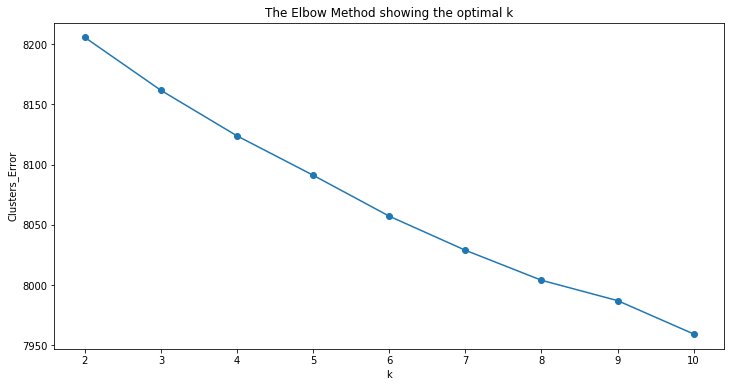

In [27]:
# In order to find the optimal number of K we use elbow method.
#Iterate on the number of clusters
cluster_error = []
range_n_clusters = range(2,11, 1)

for k in range_n_clusters:
    kmeanModel = KMeans(n_clusters=k, init='k-means++', n_init=10)
    kmeanModel.fit(X_train_lsa)
    cluster_error.append(kmeanModel.inertia_)

#Build DataFrame
clusters_df = pd.DataFrame( { "num_clusters": range_n_clusters , 'cluster_error': cluster_error } )

# Plot the elbow Plot
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_error, marker = "o" )
plt.xlabel('k')
plt.ylabel('Clusters_Error')
plt.title('The Elbow Method showing the optimal k')
plt.show()

As it can be seen from the elbow graph, the optimum number of clusters is 8, hence that will be the number that will be used and the kmeans clustering as clusterer. We will run the model to see the accuracy of the clustering technique before the visualization of the clusters. In any case we will check the accuracy trying different number of clusters to see which one fits better

In [28]:
#filter warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

#Number of clusters chosen by the elbow graph
num_clusters = 8

#Run the clustering algorithm kmeans
kmeans_model = KMeans(n_clusters=num_clusters, init='k-means++', n_init=1, max_iter=1000)

#Fit the model
kmeans = kmeans_model.fit(X_train_lsa)

#Predict the clusters and sitances between clusters
kmeans_clusters = kmeans.predict(X_train_lsa)
kmeans_distances = kmeans.transform(X_train_lsa)

# Compute the clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
clusters = kmeans.fit_predict(X_train_lsa)

# Permute the labels
labels = np.zeros_like(clusters)
for i in range(num_clusters):
    mask = (clusters == i)
    labels[mask] = mode(y_train[mask])[0]

# Compute the accuracy
accuracy_score(y_train, labels)

0.38214327451209534

If we didn´t have the labels and we had to predict the labels for the authors based on the corpus we have, we can see that we don´t have enough information to be accurate in our clustering. The best number of clusters is 8 giving an accuracy in our classification of 38% although clustering is not a classification method. Results with features obtained using bag of words are lower than the ones represented here, being 17 percentual points lower on average

In [29]:
#filter warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

#Number of clusters chosen by the elbow graph
num_clusters = 8

#Run the clustering algorithm kmeans
kmeans_model = KMeans(n_clusters=num_clusters, init='k-means++', n_init=1, max_iter=1000)

#Fit the model
kmeans = kmeans_model.fit(X_train_cvec)

#Predict the clusters and sitances between clusters
kmeans_clusters = kmeans.predict(X_train_cvec)
kmeans_distances = kmeans.transform(X_train_cvec)

# Compute the clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
clusters = kmeans.fit_predict(X_train_cvec)

# Permute the labels
labels = np.zeros_like(clusters)
for i in range(num_clusters):
    mask = (clusters == i)
    labels[mask] = mode(y_train_cvec[mask])[0]

# Compute the accuracy
accuracy_score(y_train_cvec, labels)

0.21397686104943323

#### Clustering Visualization ####

In [30]:
#Open bokeh notebook
output_notebook()

#Set up the color map
colormap = np.array(["#6d8dca", "#69de53", "#723bca", "#c3e14c", "#c84dc9", "#68af4e", "#6e6cd5",
                     "#e3be38", "#4e2d7c","#5fdfa8", "#d34690", "#3f6d31", "#d44427", "#7fcdd8", "#cb4053", "#5e9981",
                     "#803a62", "#9b9e39", "#c88cca", "#e1c37b", "#34223b", "#bdd8a3", "#6e3326", "#cfbdce", "#d07d3c",
                     "#52697d", "#7d6d33", "#d27c88", "#36422b", "#b68f79"])

#Set up the plotting conditions
plot = bp.figure(plot_width=700, plot_height=600, title="Dataset",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

#Build the Dataframe
tfidf_df = pd.DataFrame(X_train_tsne, columns=['x', 'y'])

#Add the author to the dataframe with the coordinates of each cluster
tfidf_df['Author'] = y_train.values

#Plot the graph
plot.scatter(x='x', y='y', source=tfidf_df)
hover = plot.select(dict(type=HoverTool))
hover.tooltips={"Author":"@Author"}
show(plot)

Loading BokehJS ...

In the following graph the clusters per authors are shown so that the result of the clustering can be visualized. As it is expected, there is overlap between clusters as the silhouette scores were low and the prodictive capacity of the clusters is also low.

In [39]:
#Transform kmeans distances into 2D
tsne_kmeans = tsne_model.fit_transform(kmeans_distances)

#Set up the color map
colormap = np.array(["#6d8dca", "#69de53", "#723bca", "#c3e14c", "#c84dc9", "#68af4e", "#6e6cd5",
                     "#e3be38", "#4e2d7c","#5fdfa8", "#d34690", "#3f6d31", "#d44427", "#7fcdd8", "#cb4053", "#5e9981",
                     "#803a62", "#9b9e39", "#c88cca", "#e1c37b", "#34223b", "#bdd8a3", "#6e3326", "#cfbdce", "#d07d3c",
                     "#52697d", "#7d6d33", "#d27c88", "#36422b", "#b68f79"])

#set up the graph to plot the kmeans_distances between authors
plot_kmeans = bp.figure(plot_width=700, plot_height=600, title="KMeans clustering of Authors",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

In [40]:
#Build the dataframe
kmeans_df = pd.DataFrame(tsne_kmeans, columns=['x', 'y'])

#Add the clusters author and colors
kmeans_df['cluster'] = kmeans_clusters
kmeans_df['Author'] = y_train.values
kmeans_df['colors'] = colormap[kmeans_clusters]

#Plot the clusters
plot_kmeans.scatter(x='x', y='y', 
                    color='colors', 
                    source=kmeans_df)
hover = plot_kmeans.select(dict(type=HoverTool))
hover.tooltips={"cluster":"@cluster", "Author": "@Author"}
show(plot_kmeans)

The distribution of the clusters is not homogeneus and there is overlap between them as expected from the results obtained from the cluster analysis. The scores in silhouette, completeness and homogeneity were low although they were the highest ones with the information we have. The size and shape of the clusters changes with each run not being replicable. Kmeans clustering is not stable and results change between runs and when new authors are added.
The number of texts used is not big enough for clustering due to computational constraints which contributes to the lack of stability of the clusters.

### 6. Supervised Models ###

From the results obtained in this lesson´s challenge, the same models are run on the new corpus. In this case, Tfidf is run due to the higher accuracy obtained in every model. As in the challenge, cross validation is used with five folds. In this case, the results obtained with the supervised models will be compared to the results obtained with the unsupervised ones to compare the results obtained with each of them. Additionally, due to a deeped clean up of the corpus and the increase in the number of texts per author, an increase in the accuracy obtained in each case is observed. The models used are:

1. Logistic Regression Classifier
2. Naive-Bayes
3. Multinomial
4. KNN
5. SDG Classifier
6. Random Forest
7. Linear Support Vector Machine

As in the previous case with unsupervised learning there are computing restrictions that will force the number of folds to be reduced in the case of KNN due to memory constraints. Furthermore, Gradien Boosting Model cannot be run in the whole corpus as the Virtual Machine is not able to fit the model on the training set. The number of folds is defined to be used in the supervised models.

In all cases a classification report, the overall accuracy and the confusion matrix are obtained on the test set. The overall accuracy has been picked as false positives and negatives in this case have the overall performance of the classifier is what should be maximized.

In [32]:
#KFold for cross validation analysis

kf = KFold(n_splits=5, shuffle=True, random_state=123)

#### 6.1 Logistic Regression Classifier ####

A Logistic Regression Classifier is trained using the features obtained through tfidf. Additionally, using fridsearch the parameters are tunned. As length of texts and therefore the features per author are not balanced, the class weight is set up so that is consideres unbalanced classes.

In [70]:
# Initialize and fit the model.
log_reg_tfidf = LogisticRegression(class_weight='balanced', penalty = 'l2', multi_class= 'multinomial', max_iter = 1000)

#Tune parameters: C parameter
c_param = [ 0.1, 0.5, 1 ]

#Tune the type of penalty used between l1 and l2

solver_param = ['newton-cg', 'lbfgs']

parameters = {'C': c_param, 'solver': solver_param}

#Fit parameters
log_reg_tuned_tfidf = GridSearchCV(log_reg_tfidf, param_grid=parameters, n_jobs = -1, cv=kf, verbose = 1)

#Fit the tunned classifier in the training space
log_reg_tuned_tfidf.fit(X_train_tfidf, y_train)

#Print the best parameters
print(('Best paramenters logistic regression Tfidf:\n {}\n').format(log_reg_tuned_tfidf.best_params_))    

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.5min finished


Best paramenters logistic regression Tfidf:
 {'C': 1, 'solver': 'newton-cg'}



After the parameters are tunned, the model is fit in the test dataset. As a measurement of the computing effort it requires 3.6 min to fit the test set.

In [71]:
#Once the model has been trained test it on the test dataset
log_reg_tuned_tfidf.fit(X_test_tfidf, y_test)

# Predict on test set
predtest_y_tfidf = log_reg_tuned_tfidf.predict(X_test_tfidf)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.5min finished


The model is evaluated on the test set. In this case the solver has been chosen between the different options that support multiclass classification. As it can be seen in the classification report the model presents overfitting being the precision and recall close to one in all classes expect for class five (Huxley) which is the one that reduces the overall accuracy of the model.

In [72]:
#Evaluation of the model (testing)

#Define the Target values
target_names = ['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0']

#Print the Classification Report
print(('Classification Report tfidf: \n {}').format(classification_report(y_test, predtest_y_tfidf, target_names=target_names)))

#Calculate the confusion matrix
confusion_lr_tfidf = confusion_matrix(y_test, predtest_y_tfidf)

#Print the Confusion Matrix
print(('Confusion Matrix Tfidf: \n\n {}\n').format(confusion_lr_tfidf))

#Print the overall accuracy per class
print(('Logistic Regression set accuracy Tfidf: {0:.2f} % \n').format(cross_val_score(log_reg_tuned_tfidf,
                                                                                      X_test_tfidf,
                                                                                      y_test,cv=kf).mean()*100))

Classification Report tfidf: 
              precision    recall  f1-score   support

        0.0       0.97      0.97      0.97      4042
        1.0       0.93      0.98      0.96      2119
        2.0       0.95      0.96      0.96      2963
        3.0       0.97      0.96      0.96      3195
        4.0       0.99      0.92      0.95      5314
        5.0       0.88      1.00      0.94      1064
        6.0       0.98      1.00      0.99      1388
        7.0       0.97      0.97      0.97      2473
        8.0       0.94      0.99      0.96      1595
        9.0       0.96      0.99      0.97      1518

avg / total       0.96      0.96      0.96     25671

Confusion Matrix Tfidf: 

 [[3901   20   28   17   26   14    2   16   10    8]
 [   1 2077    7   11    1    8    2    2    7    3]
 [  18   26 2834   14   16   12   10   10   16    7]
 [  26   17   27 3069   15    5    3   11   17    5]
 [  56   59   60   55 4874   87   15   41   42   25]
 [   0    0    0    0    1 1061    1  

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.1min finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.1min finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.9min finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.1min finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.0min finished


Logistic Regression set accuracy Tfidf: 84.88 % 



The logistic regression model is computationally efficient as it fits the dataset with over 80k in less than  two minutes making it a string candidate to move intro production. The overall accuracy is nearly 85% which is roughly five percentage points more than in the challenge for this unit. The accuracy is higher than the one obainted by undsupervised methdos using clustering as is much more stable. In this case, the introduction of the test set, unseen by the model is not provoking unstable classifications.

#### 6.2 Naive-Bayes Classifier: Bernoulli ####

A Bernoulli classifier has been tunned and trained in the feautures obtained through Tf-idf. In this case the simplicity of the model added to the good classification results make of this model a good candidate to move into production. The time required to train it is lower than the time required to train the logistic regression one.

In [73]:
# Initialize and fit the model.
naive_bayes_bernoulli_tfidf = BernoulliNB()

#Tune hyperparameters
#Create range of values to fit parameters

alpha = [0.001, 0.01,0.1]
parameters = {'alpha': alpha}

#Fit parameters using gridsearch
naive_bayes_bernoulli_tuned_tfidf = GridSearchCV(naive_bayes_bernoulli_tfidf, n_jobs = -1, param_grid=parameters, cv=kf,
                                                 verbose = 1)

#Fit the tunned classifier in the training space
naive_bayes_bernoulli_tuned_tfidf.fit(X_train_tfidf, y_train)

#Print the best parameters
print(('Best paramenters logistic Naive-Bayes Bernoulli Tfidf: \n{}\n').format(naive_bayes_bernoulli_tuned_tfidf.best_params_))    

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.6s finished


Best paramenters logistic Naive-Bayes Bernoulli Tfidf: 
{'alpha': 0.001}



After several runs, with different extremes in the values of the alpha parameter, the parameter chosen is always the one closer to zero. This means that the smoothing parameter is very low so the additive smoothing required is low. The model is fit within seconds which makes it a strong candidate (the best one from a computational and speed standpoint) to move intro production.

In [74]:
#Once the model has been trained test it on the test dataset
naive_bayes_bernoulli_tuned_tfidf.fit(X_test_tfidf, y_test)

# Predict on test set
predtest_y_tfidf = naive_bayes_bernoulli_tuned_tfidf.predict(X_test_tfidf)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.1s finished


The model is evaluated using cross validation and five folds. In this case as in the case of logistic regression the model presents overfitting as it can be seen from the classification report. Both precision and recall is one for this reason.

In [75]:
#Evaluation of the model (testing)

#Define the Target values
target_names = ['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0']

#Print the Classification Report
print(('Classification Report Tfidf: \n {}').format(classification_report(y_test, predtest_y_tfidf, target_names=target_names)))

#Calculate the Confusion Matrix
confusion_ber_tfidf = confusion_matrix(y_test, predtest_y_tfidf)

#Print the Confusion Matrix
print(('Confusion Matrix Tf-idf: \n\n {}\n').format(confusion_ber_tfidf))

#Print the overall accuracy
print(('Bernoulli Classifier Tf-Idf set accuracy Tf-idf: {0:.2f} % \n').format(cross_val_score(naive_bayes_bernoulli_tuned_tfidf,
                                                                                               X_test_tfidf,
                                                                                               y_test,
                                                                                               cv=kf).mean()*100))

Classification Report Tfidf: 
              precision    recall  f1-score   support

        0.0       0.98      0.97      0.98      4042
        1.0       1.00      0.92      0.96      2119
        2.0       1.00      0.91      0.95      2963
        3.0       0.93      0.99      0.96      3195
        4.0       0.99      0.93      0.96      5314
        5.0       1.00      0.86      0.92      1064
        6.0       0.93      1.00      0.96      1388
        7.0       0.76      1.00      0.86      2473
        8.0       0.99      0.93      0.96      1595
        9.0       0.99      0.97      0.98      1518

avg / total       0.96      0.95      0.95     25671

Confusion Matrix Tf-idf: 

 [[3924    0    0   22    1    0    5   89    0    1]
 [   5 1946    3   22    3    0   13  121    0    6]
 [  18    3 2689   57   11    0   37  141    2    5]
 [   0    0    0 3163    0    0    3   29    0    0]
 [  29    1    1   89 4960    1   23  204    1    5]
 [  18    1    1   17   12  910   16 

[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.0s finished


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.0s finished


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.9s finished


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.9s finished


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.0s finished


Bernoulli Classifier Tf-Idf set accuracy Tf-idf: 82.53 % 



The overall accuracy of the model is slightly lower than the accuracy obtained with the logistic regression classifier. However, the time required to fit the model is at least one tenth of the time required for the logistic regression presenting both overfitting. In this case is class seven (Shaw) the one that shows the lowest precision being the one that determines the lower value of the overall accuracy when compared to the Bernoulli model. Hence, if overall accuracy is what is tried to be improved, this is the best model with a very small loss of accuracy

#### 6.3 Naive-Bayes Classifier: Multinomial ####

A multinomial classifier is trained on the features obtained using tfidf and evaluated on the holdout. In this case, as in the previous Navy Bayes classification used, alpha always gets the value cloaer to zero, therefore there is no additive smoothing used in this classifier. From a compuational effort standpoint, as in the previous case, this is the one that requires less time to fit making it a strong candidate to move into production.

In [76]:
# Initialize and fit the model.
naive_bayes_multinomial_tfidf = MultinomialNB()

#Tune hyperparameters
#Create range of values to fit parameters

alpha = [0.01,0.1,0.5,1]
parameters = {'alpha': alpha}

#Fit parameters using gridsearch
naive_bayes_multinomial_tuned_tfidf = GridSearchCV(naive_bayes_multinomial_tfidf, n_jobs = -1, param_grid=parameters, 
                                                   cv=kf, verbose = 1)

#Fit the tunned classifier in the training space
naive_bayes_multinomial_tuned_tfidf.fit(X_train_tfidf, y_train)

#Print the best parameters
print(('Best paramenters Naive-Bayes Multinomial Tfidf:\n {}\n').format(naive_bayes_multinomial_tuned_tfidf.best_params_))    

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done   5 out of  20 | elapsed:    0.2s remaining:    0.6s


Best paramenters Naive-Bayes Multinomial Tfidf:
 {'alpha': 0.01}



[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.5s finished


The value of alpha is in all trials the closest one to zero being the additive smoothing lose. In this case the time required for fitting is less than one minute. The model is then evaluated on the test set. For that, the first step is to fit the test hodout of the dataset.

In [77]:
#Once the model has been trained test it on the test dataset
naive_bayes_multinomial_tuned_tfidf.fit(X_test_tfidf, y_test)

# Predict on test set
predtest_y_tfidf = naive_bayes_multinomial_tuned_tfidf.predict(X_test_tfidf)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.9s finished


The model presents overfitting and the accuracy is slightly higher than in the previous case 3% more. The confusion matrix presents a lower number of false positives and negatives for all categories, taking into account that the size of each of them is different results are consistent across all of them.

In [78]:
#Evaluation of the model (testing)

#Define the Target values
target_names = ['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0']

#Print the classification report
print(('Classification Report tfidf: \n {}').format(classification_report(y_test, predtest_y_tfidf, target_names=target_names)))
#Calculate the confusion matrix
confusion_mn_tfidf = confusion_matrix(y_test, predtest_y_tfidf)

#Print the confusion matrix
print(('Confusion Matrix Tf-idf: \n\n {}\n').format(confusion_mn_tfidf))

#Print the overall accuracy
print(('Multinomial Classifier set accuracy Tf-idf: {0:.2f} % \n').format(cross_val_score(naive_bayes_multinomial_tuned_tfidf,
                                                                                       X_test_tfidf,
                                                                                       y_test,
                                                                                       cv=kf).mean()*100))

Classification Report tfidf: 
              precision    recall  f1-score   support

        0.0       0.99      1.00      0.99      4042
        1.0       1.00      0.99      0.99      2119
        2.0       0.99      0.99      0.99      2963
        3.0       1.00      0.99      0.99      3195
        4.0       0.99      1.00      0.99      5314
        5.0       0.99      1.00      0.99      1064
        6.0       1.00      1.00      1.00      1388
        7.0       1.00      1.00      1.00      2473
        8.0       1.00      0.99      0.99      1595
        9.0       1.00      0.99      0.99      1518

avg / total       0.99      0.99      0.99     25671

Confusion Matrix Tf-idf: 

 [[4026    2    0    3    9    0    0    1    1    0]
 [   4 2101    2    2    7    1    0    2    0    0]
 [   8    0 2935    2   11    1    2    2    0    2]
 [   7    0    6 3173    5    0    1    2    0    1]
 [   6    1    5    4 5289    4    2    1    2    0]
 [   2    0    0    0    2 1059    1 

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.8s finished


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.7s finished


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.8s finished


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.8s finished


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.8s finished


Multinomial Classifier set accuracy Tf-idf: 87.02 % 



The time required to fit the model is lower than in any other case presenting a higher accuracy. In this case, the accuracy is close to 87% while the classification report shows values close to one, showing that there is overfitting. Hence, from the classifiers evaluated until now this is the one that presents better results, from an accuracy and a computational effort perspective. This is the best candidate to move into production for the moment.

#### 6.4 KNeighbors Classifier (using LSA) ####

As the Kneighbors classifier cannot be fit on the features obtained using tfidf, the model is fit on the features obtained through LSA reducing the dimensionallity of them. In this case the computing effort required is higher than in the logistic regression and Naive Bayes classifiers. Weights are assigned as distances to points to make the classifier comparable to the results obtained using clustering. Addityionally, the number of neighbors has been restricted to nine from the results obtained in the challenge of this lesson. 

In [33]:
# Initialize and fit the model.
KNN_lsa = KNeighborsClassifier(weights = 'distance')

#Tune hyperparameters
#Create range of values to fit parameters

neighbors = [3, 5, 7,9]

#Fit parameters
parameters = {'n_neighbors': neighbors}

#Fit parameters using gridsearch
KNN_tuned_lsa = GridSearchCV(KNN_lsa, param_grid=parameters, n_jobs = -1, cv=kf, verbose = 1)

#Fit the tunned classifier in the training space
KNN_tuned_lsa.fit(X_train_lsa, y_train)

#Print the best parameters
print(('Best paramenters KNN LSA:\n {}\n').format(
KNN_tuned_lsa.best_params_))    

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  4.2min finished


Best paramenters KNN LSA:
 {'n_neighbors': 9}



Once the parameters are obtained the model is run on the holdout of the dataset.

In [34]:
#Once the model has been trained test it on the test dataset
KNN_tuned_lsa.fit(X_test_lsa, y_test)

# Predict on test set
predtest_y_lsa = KNN_tuned_lsa.predict(X_test_lsa)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 39.7min finished


The model is evaluated using the classification report, confusion matrix and overall accuracy. In this case, the model presents overfitting, as usual for a KNN model with the size of this dataset. As it is usual with KNN, it presents overfit in the case that lsa is applied. The dimensionality reduction has been down to 400 features.

In [35]:
#Evaluation of the model (testing)

#Define targets
target_names = ['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0']

#Print classification report
print(('Classification Report KNN LSA: \n {}\n').format(classification_report(y_test, predtest_y_lsa, target_names=target_names)))

#Calculate confusion matrix
confusion_knn_lsa = confusion_matrix(y_test, predtest_y_lsa)

#Print confusion matrix
print(('Confusion Matrix KNN LSA: \n\n {}\n\n').format(confusion_knn_lsa))

#Print overall accuracy
print(('KNN LSA accuracy: {0:.2f} %\n').format(cross_val_score(KNN_tuned_lsa, X_test_lsa, y_test,cv=kf).mean()*100))

Classification Report KNN LSA: 
              precision    recall  f1-score   support

        0.0       1.00      1.00      1.00      4042
        1.0       1.00      1.00      1.00      2119
        2.0       1.00      1.00      1.00      2963
        3.0       1.00      1.00      1.00      3195
        4.0       1.00      1.00      1.00      5314
        5.0       1.00      1.00      1.00      1064
        6.0       1.00      1.00      1.00      1388
        7.0       1.00      1.00      1.00      2473
        8.0       1.00      1.00      1.00      1595
        9.0       1.00      1.00      1.00      1518

avg / total       1.00      1.00      1.00     25671


Confusion Matrix KNN LSA: 

 [[4042    0    0    0    0    0    0    0    0    0]
 [   0 2119    0    0    0    0    0    0    0    0]
 [   0    0 2963    0    0    0    0    0    0    0]
 [   0    0    0 3195    0    0    0    0    0    0]
 [   0    0    0    0 5314    0    0    0    0    0]
 [   0    0    0    0    0 1064  

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 28.0min finished


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 27.7min finished


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 27.5min finished


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 27.6min finished


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 27.8min finished


KNN LSA accuracy: 68.05 %



In this case, KNN has only been able to run using the LSA features. Compared to a small subset of features when factioning the initial dataset, the result is a bit better. From 52% approx to 68%. In this case it is nort worth using this algorithm as it yields a low accuracy compared to the Naive Bayes algorithms and it is very intensive in computing effort.

#### 6.5 SGD Classifier ####

The SGD Classifier uses regularized linear models with stochastic gradient descendent learning. The model is updated in its learning rate after the gradient of the loss is estaimated for each sample. This classifier can work with sparse data se the one obtained from tfidf. In this case from the types of penalties the algorithm accepts, it uses L2 instead of a combination of L! and L2 implemented through Elastic Net. 

In [81]:
# Initialize and fit the model.
SGD_tfidf = SGDClassifier(class_weight = 'balanced', max_iter=1000)

#Tune hyperparameters
#Create range of values to fit parameters

loss_param = ['hinge', 'squared_hinge']
penalty_param = ['elasticnet', 'l2' ]
alpha_param = [1, 0.0001, 0.001, 0.01, 0.1]

#Fit parameters
parameters = {'loss': loss_param,'penalty': penalty_param,'alpha': alpha_param}

#Fit parameters using gridsearch
SGD_tuned_tfidf = GridSearchCV(SGD_tfidf, param_grid=parameters,  n_jobs = -1, cv=kf, verbose = 1)

#Fit the tunned classifier in the training space
SGD_tuned_tfidf.fit(X_train_tfidf, y_train)

#Print the best parameters
print(('Best paramenters SDG Tfidf:\n {}\n').format(SGD_tuned_tfidf.best_params_))    

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 13.7min finished


Best paramenters SDG Tfidf:
 {'alpha': 0.0001, 'loss': 'hinge', 'penalty': 'l2'}



The parameters show that the smooting continues to be loose as a first option as it is a regression with a gradient descendent algorithm. Regarding the loss, the hinge loss is used which means that the real loss, in case it is not convergent due to the sparse data used is replaced by the upper bond forcing its convergence. Time required is significanlty higher than in the case of the Naive Bayes classifiers

In [82]:
#Once the model has been trained test it on the test dataset
SGD_tuned_tfidf.fit(X_test_tfidf, y_test)

# Predict on test set
predtest_y_tfidf = SGD_tuned_tfidf.predict(X_test_tfidf)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 17.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 46.0min finished


This model presents overfitting as all precision and recall are equal to one for every class. The confusion matrix shows a lower number of false negatives and positives per class being more or less evenly represented except for class five.

In [83]:
#Evaluation of the model (testing)

#Define the Target values
target_names = ['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0']

#Print the Classification report
print(('Classification Report Tfidf: \n {}\n').format(classification_report(y_test, predtest_y_tfidf,target_names=target_names)))

#Calculate the confusion Matrix
confusion_sgd_tfidf = confusion_matrix(y_test, predtest_y_tfidf)

#Print the Confusion Matrix
print(('Confusion Matrix Tfidf: \n\n {}\n\n').format(confusion_sgd_tfidf))

#Print the SGD overall accuracy
print(('SGD accuracy Tfidf: {0:.2f} %\n').format(cross_val_score(SGD_tuned_tfidf, X_test_tfidf, y_test,cv=kf).mean()*100))

Classification Report Tfidf: 
              precision    recall  f1-score   support

        0.0       1.00      1.00      1.00      4042
        1.0       1.00      1.00      1.00      2119
        2.0       1.00      1.00      1.00      2963
        3.0       1.00      1.00      1.00      3195
        4.0       1.00      0.99      1.00      5314
        5.0       0.99      1.00      1.00      1064
        6.0       0.99      1.00      1.00      1388
        7.0       1.00      1.00      1.00      2473
        8.0       1.00      1.00      1.00      1595
        9.0       1.00      1.00      1.00      1518

avg / total       1.00      1.00      1.00     25671


Confusion Matrix Tfidf: 

 [[4035    0    2    1    1    1    1    1    0    0]
 [   0 2116    2    1    0    0    0    0    0    0]
 [   1    1 2958    0    0    1    1    1    0    0]
 [   2    0    0 3191    0    0    0    0    0    2]
 [  11    3    1    9 5269    4    4    4    6    3]
 [   0    0    0    0    0 1064    0 

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 35.6min finished


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 36.1min finished


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 35.6min finished


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 34.4min finished


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 35.3min finished


SGD accuracy Tfidf: 87.12 %



In this case, the overall accuracy is 87%, very similar to the overall accuracy obtained using the multinomial classifier. The computational effort required by this model to achieve this accuracy is much higher than in the case of the multinomial classifier (46 min vs 0.9 s). Hence, from a production perspective, this model would not be recommended to move into production despite of its high accuracy.

#### 6.5 Random Forest ####

The hyperparamters of the random forest model have been tuned one by one. After trying to tune them all at once, a significant increase of the overall performance of the classifier was obtained with the proposed method (one by one). The parameters to be tuned are (in the same order as the hyperparameter tuning has been performed):

  - N_estimators determining the number of trees that will be part of the algorithm.
  - Max depth determining the size of the tree.

In [36]:
# Initialize and fit the model.
rf_tfidf = RandomForestClassifier(class_weight = 'balanced')

#Tune hyperparameters
#Create range of values to fit parameters

n_estimators_param = np.arange(150,191,10)
max_depth_param = np.arange(50,66,5)

#Fit parameters
parameters = {'n_estimators': n_estimators_param, 'max_depth': max_depth_param}

#Fit parameters using gridsearch
rf_tuned_tfidf = GridSearchCV(rf_tfidf, param_grid=parameters,  n_jobs = -1, cv=kf, verbose = 1)

#Fit the tunned classifier in the training space
rf_tuned_tfidf.fit(X_train_tfidf, y_train)

#Print the best parameters
print(('Best paramenters Random Forest Tfidf:\n {}\n').format(rf_tuned_tfidf.best_params_))    

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.9min finished


Best paramenters Random Forest Tfidf:
 {'max_depth': 60, 'n_estimators': 190}



The tuned model is fit and run on the test set

In [37]:
#Once the model has been trained test it on the test dataset
rf_tuned_tfidf.fit(X_test_tfidf, y_test)

# Predict on test set
predtest_y_tfidf = rf_tuned_tfidf.predict(X_test_tfidf)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 14.6min finished


The overall accuracy of the model has significantly increase compared to the previous classifiers achieving 73%. This result is low for the type of classifier used. Additionally it is lower than the results obtained with other classifiers. In this case, author seven is the one that is decreasig the overall accuracy.

In [38]:
#Evaluation of the model (testing)

#Define the targets
target_names = ['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0']

#Print the classification report
print(('Classification Report RF Tfidf: \n {}\n').format(
    classification_report(y_test, predtest_y_tfidf,
                          target_names=target_names)))

#Calculate the confusion matrix
confusion_rf_tfidf = confusion_matrix(y_test, predtest_y_tfidf)

#Print the confusion matrix
print(('Confusion Matrix RF Tfidf: \n\n {}\n\n').format(confusion_rf_tfidf))

#Print the overall accuracy
print(('Random Forest accuracy RF Tfidf: {0:.2f} %\n').format(cross_val_score(rf_tuned_tfidf,
                                                                              X_test_tfidf,
                                                                              y_test, cv=kf).mean()*100))

Classification Report RF Tfidf: 
              precision    recall  f1-score   support

        0.0       0.97      0.92      0.94      4042
        1.0       0.95      0.92      0.93      2119
        2.0       0.95      0.91      0.93      2963
        3.0       0.89      0.94      0.92      3195
        4.0       0.98      0.88      0.93      5314
        5.0       0.95      0.94      0.95      1064
        6.0       0.94      0.97      0.96      1388
        7.0       0.73      0.98      0.84      2473
        8.0       0.95      0.94      0.94      1595
        9.0       0.98      0.91      0.94      1518

avg / total       0.93      0.92      0.93     25671


Confusion Matrix RF Tfidf: 

 [[3713   12   28   67   21    8   12  161   13    7]
 [   9 1941   17   36    9    6    6   80   10    5]
 [  13   22 2689   60   16    6   16  126   11    4]
 [  26   14   14 3013   10    9    6   84   14    5]
 [  49   29   45  121 4701   16   32  285   27    9]
 [   3    3    2    6    3 1004

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 12.3min finished


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 12.0min finished


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 11.9min finished


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 12.1min finished


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 11.8min finished


Random Forest accuracy RF Tfidf: 73.34 %



This classifier requires more time to run than the Naive Bayes ones and throws poorer results than them. Author seven "Sahw" is the one that is reducing the overall accuracy.

#### 6.6 Support Vector Machine ####

A linear support vector classifier has been set up and tuned on the training data and run on the test set. The hyperparameters that have been tuned are:

  - C parameter, acting on the margin hyperplane having a bigger margin when C is smaller. (The value of C will tell the SVM how much misclassification is to be avoided).
  - The loss parameter.

In this case the crammer singer algorithm is used to solve the multiclass classification problem. This algorithm optimizes the joint objective over all classes but it is not interesting from a production standpoint as it rarely leads to better accuracy and is more expensive to compute. Due to the size of the feature´s space the linear SVC has been used instead of the SVC due to computational restrictions.

In [40]:
# Initialize and fit the model.
LSVC = LinearSVC(class_weight='balanced', multi_class = 'crammer_singer')

#Tune hyperparameters
#Create range of values to fit parameters

loss_param = ['hinge','squared_hinge']
C_param = [0.1, 1, 10, 100]

#Fit parameters
parameters = {'loss': loss_param, 'C': C_param}

#Fit parameters using gridsearch
LSVC_tuned = GridSearchCV(LSVC, param_grid=parameters,  n_jobs = -1, cv=kf, verbose = 1)

#Fit the tunned classifier in the training space
LSVC_tuned.fit(X_train_tfidf, y_train)

#Print the best parameters
print(('Best paramenters Linear SVC Tfidf:\n {}\n').format(LSVC_tuned.best_params_))    

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    8.4s finished


Best paramenters Linear SVC Tfidf:
 {'C': 1, 'loss': 'hinge'}



Once the parameters have been tunned the model is fit in the testing dataset

In [41]:
#Once the model has been trained test it on the test dataset
LSVC_tuned.fit(X_test_tfidf, y_test)

# Predict on test set
predtest_y_tfidf = LSVC_tuned.predict(X_test_tfidf)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   21.2s finished


Although from a computational perspective it requires more effort, it presents better results than the previous algorithms. In this case, nearly 87% has been achieved competing agasint the multiclass algorithm in terms of accuracy but not in terms of computational effort.

In [42]:
#Evaluation of the model (testing)

#Define the targets
target_names = ['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0']

#Print the classification report
print(('Classification Report Tfidf: \n {}\n').format(
    classification_report(y_test, predtest_y_tfidf,
                          target_names=target_names)))

#Calculate the confusion matrix
confusion_svc_tfidf = confusion_matrix(y_test, predtest_y_tfidf)

#Print the confusion matrix
print((
    'Confusion Matrix Tfidf: \n\n {}\n\n').format(confusion_svc_tfidf))

#Print the overall accuracy
print((
    'Linear SVC accuracy Tfidf: {0:.2f} %\n'
).format(cross_val_score(LSVC_tuned, X_test_tfidf, y_test,cv=kf).mean()*100))

Classification Report Tfidf: 
              precision    recall  f1-score   support

        0.0       1.00      1.00      1.00      4042
        1.0       1.00      1.00      1.00      2119
        2.0       1.00      1.00      1.00      2963
        3.0       1.00      1.00      1.00      3195
        4.0       1.00      0.99      1.00      5314
        5.0       1.00      1.00      1.00      1064
        6.0       1.00      1.00      1.00      1388
        7.0       1.00      1.00      1.00      2473
        8.0       1.00      1.00      1.00      1595
        9.0       0.99      1.00      1.00      1518

avg / total       1.00      1.00      1.00     25671


Confusion Matrix Tfidf: 

 [[4037    0    3    1    0    0    0    1    0    0]
 [   0 2119    0    0    0    0    0    0    0    0]
 [   0    0 2963    0    0    0    0    0    0    0]
 [   2    0    0 3191    0    0    0    1    0    1]
 [   8    4    6    5 5271    1    2    5    5    7]
 [   0    0    0    0    0 1064    0 

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   20.5s finished


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   16.4s finished


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   16.7s finished


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   16.9s finished


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   16.4s finished


Linear SVC accuracy Tfidf: 86.48 %



The algorithm presents overfitting as it can be seen from the classification report. Although recall and precision are one, in reality they are lower than one having an overall accuracy of 86.5%. Furthermore, the time required to fit the dataset is higher than the one required wuth the Naive Bayes algorithms.

### Conclusions ###

The aim of this capstone Project is to classify ten authors using 10 novels available in the Gutenberg project. Ti classify the authors unsupervised and supervised models have been used. Due to computational restrictions, the number of novels used per author has been reduced to siz novels per author, maintaining the number of them.

From an unsupervised learning standpoint, clustering and LSA has been used. The first one meanshift, kmeans, affinity and spectral clustering have been compared. From the different alternatives available, kmeans seems to be the more reasonable one when clustering the authors. To determine which one is better meanshift has been run with different bandwidths giving as a result one cluster whil affinity has given an excessively high number of clusters (more than 600). Both options have been discarded and kmeans has been compared to spectral clustering. In this case, several scores have been used: silhouette, homogeneity, completeness V-measure and adjusted rand index as we have the ground truth as the texts are tagged. When running the clusters from one to 10 (same as the number of authors), the number of clusters that score higher values is eight. This result is not stable and it has varied in different trials, first being 4 then 6 and last 8. Additionally, when running the elbow method to compare the best cluster when using kmeans, the optimum number of clusters also varies and sometimes gives different results. In this case and for the last three runs, it has remained stable and equal to eight clusters.

Once the clusters have been made, it can be seen that the authors are not consistently classified. The components obtained from LSA, target more than one author in the first component, and one author per component, sometimes repeating the author for different components. The authors and the distribution targeted by each component is different as it happens with the clusters. The accuracy when classifying the authors through clustering is roughly 38% when using LSA higher  than the result obtained when using bag of words: 21%.

Unsupervised and supervised models have been permuted trying to achieve the best overall accuracy. To do this cross validation over five folds has been used over all the models. The best accuracy has been achieved using SGD classifier 87.12% followed by Multinomial classifier 87.02%. From a computational cost standpoint it makes more sense to use Multinomial as it requires less time to achieve very similar results. The results obtained for all the models that have been tried are:

1. SGD Classifier: 87.12%
2. Multinomial Classifier: 87.02%
3. Linear Support Vector Machine: 86.48%
4. Logistic Regression: 84.88%
5. Bernouilli Classifier: 82.53%
6. Random Forest: 73.34%
7. KNN: 68.05%.

In all cases the results obtained are higher when using tfidf than when using bag of words. Additionally, the results obtained when using LSA are higher in the case of KNN moving from 51% with tfidf to 68.05% when using LSA.
From a production perspective, the best algorithm is the Multinomial classifier and when the supervised models are compared to the unsupervised models, the former score higher results when classifying texts.